<a href="https://colab.research.google.com/github/OVP2023/time_series/blob/main/dz2_time_series_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


    Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
    Приблизьте оба варианта моделями из класса MA.
    Оцените качество и пришлите соображения, почему была выбрана та или иная модель.


In [42]:
import pandas as pd
import numpy as np

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
mean_monthly_temp = pd.read_csv("/content/drive/MyDrive/Datasets/VR/mean-monthly-air-temperature-deg.csv")
airlines_passengers = pd.read_csv("/content/drive/MyDrive/Datasets/VR/international-airline-passengers.csv")

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

all_series = {
    "Нестационарный временной ряд   International airline passengers ...": airlines_passengers["Count"],
    "Стационарный временной ряд Mean monthly air temperature ...": mean_monthly_temp["Deg"]
}

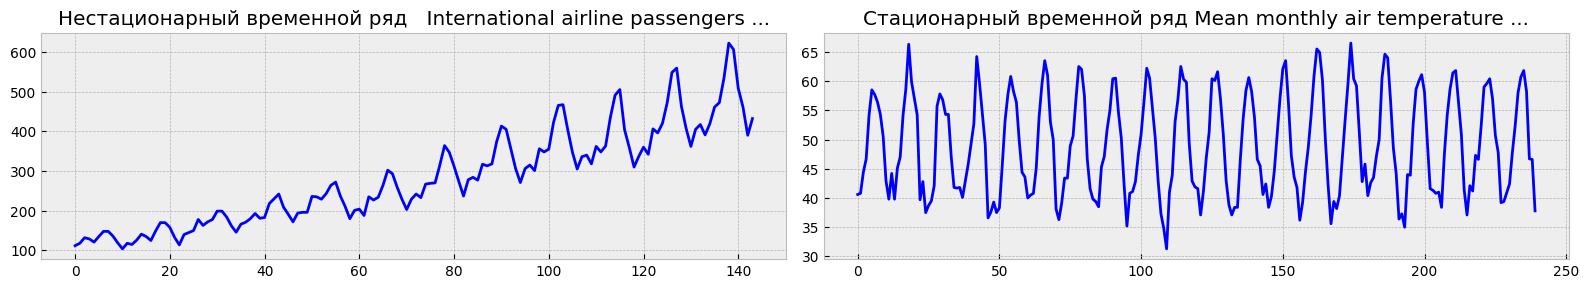

In [46]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

In [47]:
#Так как в стационарном временном ряду mean_monthly_temp["Deg"] нет сезонности и тренда, достаточно использовать скользящее среднее

def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()



In [48]:
ser = moving_average(mean_monthly_temp["Deg"], 2)

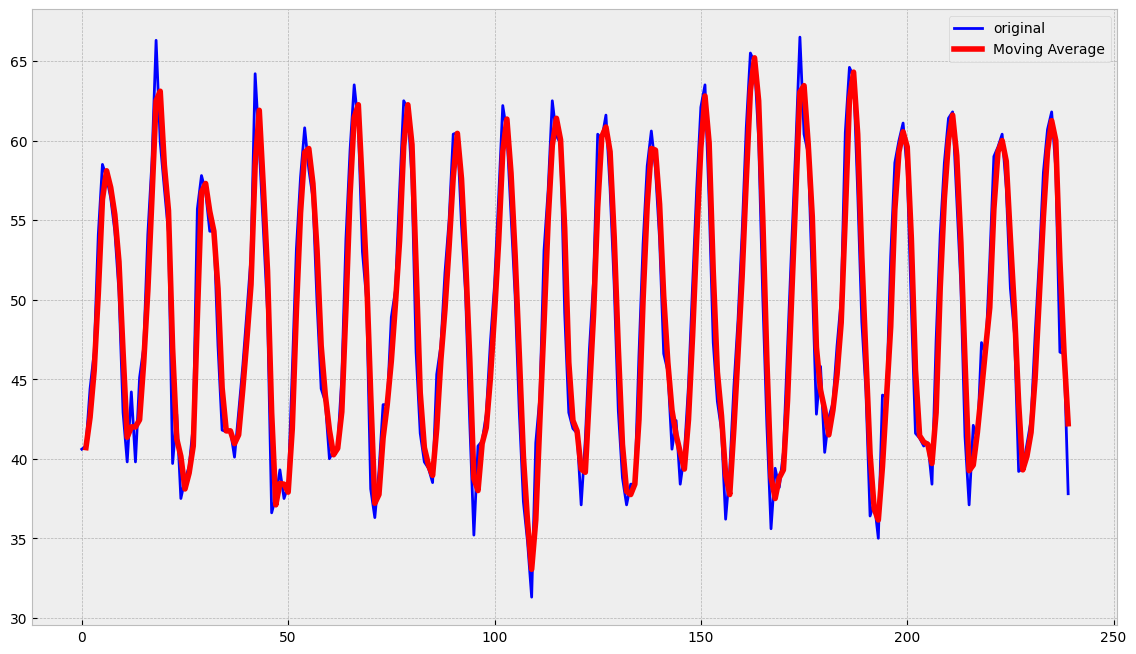

In [49]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(mean_monthly_temp["Deg"], color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [65]:
#Добавим взвешенное скользящее среднее и экспоненциальное сглаживание для стационарного временного ряда

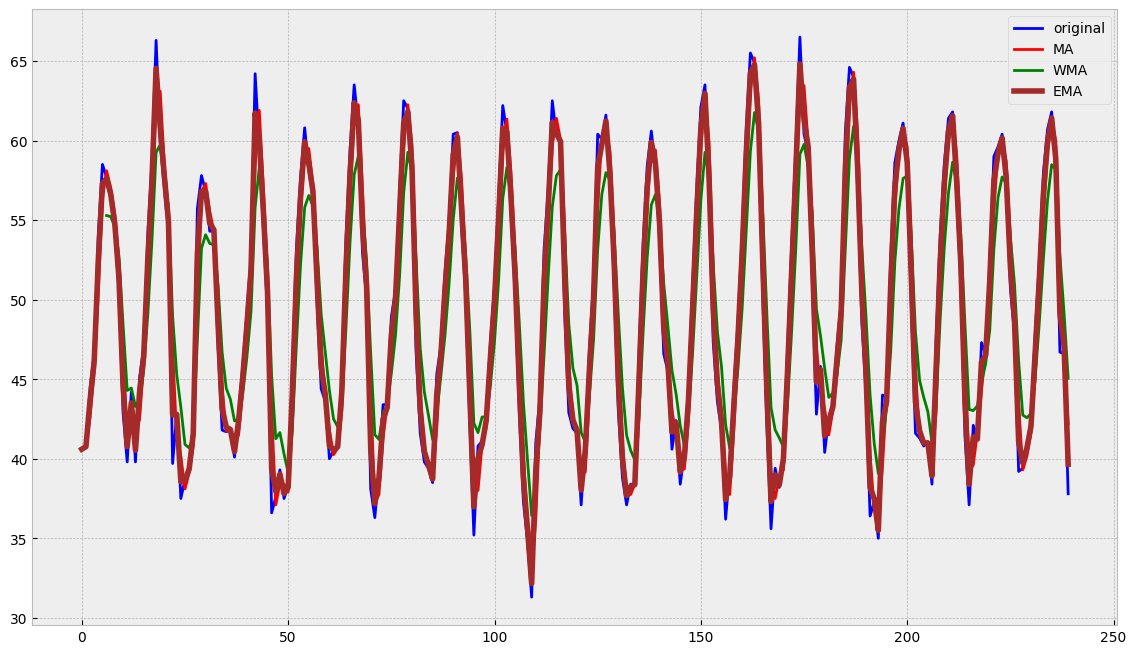

In [82]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

ema = exponential_moving_average(mean_monthly_temp["Deg"], 0.8)
wma = weighted_moving_average(mean_monthly_temp["Deg"], 7, [1,1,1,1,1,8,10])
ma = moving_average(mean_monthly_temp["Deg"], 2)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(mean_monthly_temp["Deg"], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='brown', linewidth='4', label='EMA')
    plt.legend()

In [78]:
#Сравним MSE у MA, EMA, WMA сглаживаний
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

series = mean_monthly_temp["Deg"]
train, test, val = series[:60], series[60:70], series[70:]

result = moving_average(mean_monthly_temp["Deg"], 2)
predictions = result[-len(test):]
error = mean_squared_error(predictions, test)
print('ma ',error)


result = exponential_moving_average(mean_monthly_temp["Deg"], 0.8)
predictions = result[-len(test):]
error = mean_squared_error(predictions, test)
print('ema ',error)

result = weighted_moving_average(mean_monthly_temp["Deg"], 7, [1,1,1,1,1,8,10])
predictions = result[-len(test):]
error = mean_squared_error(predictions, test)
print('wma ',error)


ma  43.312249999999985
ema  63.00607268927367
wma  28.637495274102076


In [ ]:
#Более низкое значение MSE указывает на то, что прогнозы модели ближе к истинным значениям, что отражает более высокую общую эффективность

In [29]:
#Так как в не стационарном временном ряду airlines_passengers["Count"] есть сезонность и тренд, то используем метод Хольт-Винтерс / Тройное экспоненциальное сглаживание
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def plot_tema(alpha, beta, gamma, ser=airlines_passengers["Count"], ser_to_plot=airlines_passengers["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

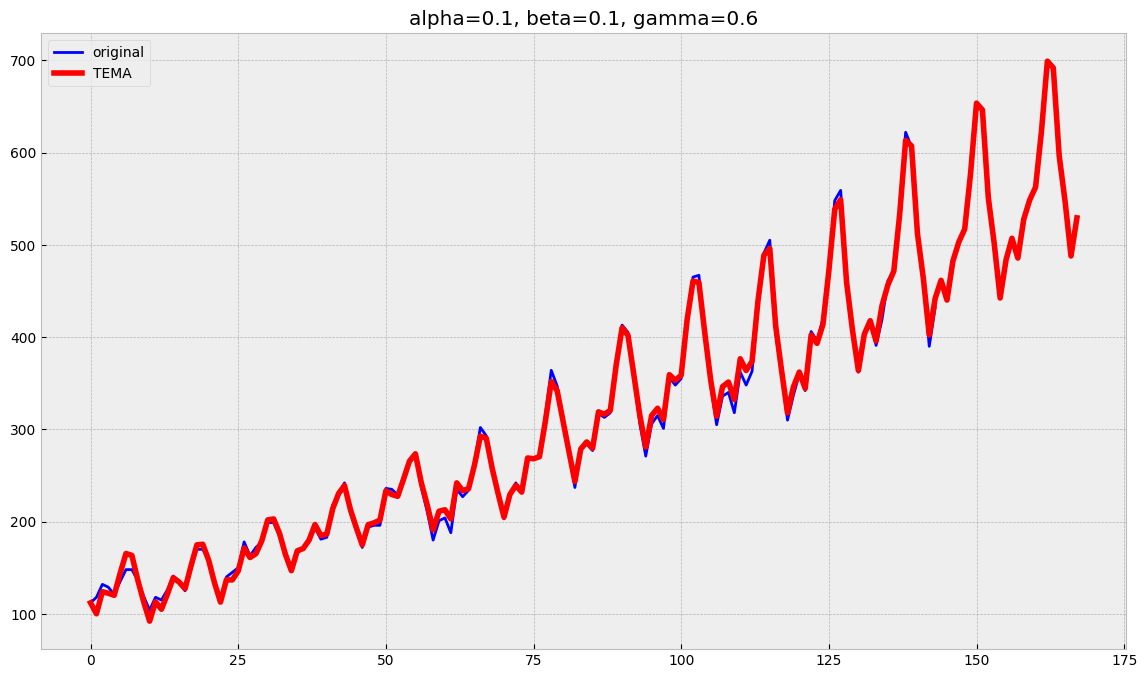

In [66]:
plot_tema(0.1, 0.1, 0.6)

In [73]:
#Добавим экпоненциальное сглаживание и взвешенное скользящее среднее для нестационарного временного ряда

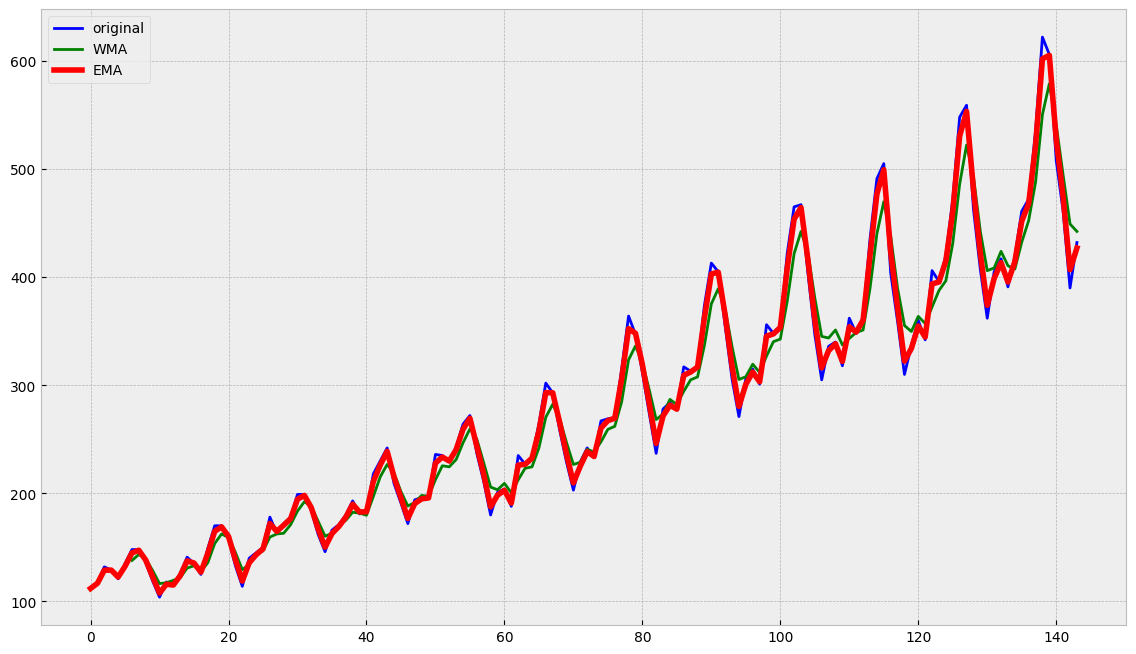

In [72]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

ema = exponential_moving_average(airlines_passengers["Count"], 0.8)
wma = weighted_moving_average(airlines_passengers["Count"], 7, [1,1,1,1,1,8,10])
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers["Count"], color='blue',label='original')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='red', linewidth='4', label='EMA')
    plt.legend()

